## Add Aero Forces

need to add aero moments to my aero model will do for a simple model and check result with previous method

### Preamble

In [1]:
import sympy as sym
import sympy.physics.mechanics as me
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import sympyTransforms as symt
import custom_plot_objects as cpo
import FwtModels as fm
import FwtModels.dof2 as dof2
import FwtModels.RollingModel as rm
import FwtModels.AeroModels as ams
import FwtModels.AssumedShapesNonLin as asnl

me.mechanics_printing()



### Define the Model

#### Create Parameter instance

In [2]:
half = sym.Rational(1,2)

# lets go for B2T2 (so 5 DoF)
p = fm.FwtParameters(3+1)

## Create some global parameters
p.c = fm.FwtVariable(0.15,'c') # chord of wing

p.rho_t = fm.FwtVariable(2.75/1.345,'rho_t') # mass per unit length for the wing
p.s_t = fm.FwtVariable(1.345,'s_t') # chord of wing
p.ratio_fwt = fm.FwtVariable(0.345/1.345,'sigma') # chord of wing

# main Wing Structural Parameters
p.y_0 = sym.Symbol('y_0')
p.x_0 = sym.Symbol('x_0')

p.e_0 = fm.FwtVariable(0.25,'e_0')
p.x_f0 = fm.FwtVariable(0.5,'x_f0')
#p.x_f0 = sym.Rational(1,4)*p.c + p.e_0*p.c

p.s_0 = fm.FwtVariable(1,'s_0') # chord of wing
#p.s_0 = p.s_t*(1-p.ratio_fwt)# span

## force soome frequencies
#p.f_0 = fm.FwtVariable(2,'f_0') # first Bending mode frequency
#p.EI = (2*sym.pi*p.f_0/sym.Float(3.516))**2*p.rho_0*sym.Abs(p.c)*(p.s_0+p.s_1)**4
p.EI = fm.FwtVariable(59.375,'EI')

#p.f_1 = fm.FwtVariable(4,'f_1') # first Bending mode frequency
#p.I_0 = p.rho_t*p.c*(half*p.rho_t-p.x_f0)
#p.GJ = (sym.Rational(4,3)*p.f_1*(p.s_0+p.s_1))**2*p.I_0
p.GJ = fm.FwtVariable(855.625,'GJ')

## FWTD Structural Parameters
p.y_1 = sym.Symbol('y_1')
p.x_1 = sym.Symbol('x_1')

p.e_1 = fm.FwtVariable(0.25,'e_1')
p.x_f1 = sym.Rational(1,4)*p.c + p.e_1*p.c
p.Lambda = fm.FwtVariable(np.deg2rad(10),'Lambda')


p.s_1 = fm.FwtVariable(0.345,'s_1') # chord of wing
#p.s_1 = p.s_t * p.ratio_fwt # span

p.m_1 = fm.FwtVariable(0.3,'m_1')
p.I_xx_1 = sym.Rational(1,12)*p.m_1*p.s_1**2 # inertia of FWT (uniform bar)

## Aero Parameters
p.rho = fm.FwtVariable(1.225,'rho') # density
p.V = fm.FwtVariable(10,'V') # velocity
p.g  = fm.FwtVariable(9.81,'g') # gravity
p.alpha_r = fm.FwtVariable(np.deg2rad(3),'alpha_r') # root AoA
p.M_thetadot = fm.FwtVariable(1.2,'M_thetadot')


## Main Wing Specific
p.a_0 = fm.FwtVariable(2*np.pi,'a_0') # C_L of wing

## FWT Specific
p.a_1 = p.a_0 - p.a_0/p.s_1*p.y_1
p.alpha_1 = fm.FwtVariable(0,'alpha_1') # FWT alpha
p.alphadot_1 = fm.FwtVariable(0,'alphadot_1') # FWT alphadot



#### Create Transforms

In [3]:
#get shape functions for main wing
z_0,tau_0 = asnl.ShapeFunctions_BN_TM(2,1,p.q[:-1],p.y_0,p.x_0,p.x_f0,0,factor=1)

#define wing frame
wing_frame = symt.HomogenousTransform().R_y(p.alpha_r)
#z_w = sym.Function('z_w')(p.q[0],p.q[1],p.y_w,p.x_w)
#create flexielement
M = fm.MassMatrix(p.rho_t/p.c)
ele = fm.FlexiElement(wing_frame,M,p.x_0,p.y_0,z_0,p.c,p.s_0,p.x_f0,p.EI,p.GJ)

M_fwt = fm.MassMatrix(p.m_1,I_xx = p.I_xx_1)

fwt_frame = wing_frame.Translate(p.c/2,p.s_0,z_0.subs({p.x_0:p.c/2,p.y_0:p.s_0})).R_x(-p.q[-1])
fwt_com_frame = fwt_frame.Translate(0,p.s_1/2,0)
bar_fwt_rhs = fm.RigidElement(fwt_com_frame,M_fwt)

fwt_GravityForces = ams.GravityModel(p,fwt_com_frame,sym.Matrix([0,0,-p.g*p.m_1]))
fwt_GravityForces(p.GetNumericTuple([0]*8,0),[0]*8,0)

array([[-2.93896672],
       [-2.93896672],
       [ 1.24906086],
       [ 0.50697176]])

In [4]:
wing_GravityForces = ams.ContinuousGravityModel(p,wing_frame.Translate(p.x_0,p.y_0,z_0),
                                                sym.Matrix([0,0,-p.g*p.rho_t/p.c]),(p.x_0,0,p.c),(p.y_0,0,p.s_0))

wing_frame_aero = wing_frame.Translate(p.x_f0,p.y_0,z_0.subs(p.x_0,p.x_f0))
wing_AeroForces = ams.AeroModelv3(p,wing_frame_aero,p.a_0,(p.y_0,0,p.s_0),p.alpha_r,tau_0,tau_0.diff(me.dynamicsymbols._t),p.M_thetadot,p.e_0)


tau_s0 = tau_0.subs(p.y_0,p.s_0)
alpha_fwt = tau_s0 + p.alpha_1
alphadot_fwt = tau_s0.diff(me.dynamicsymbols._t) + p.alphadot_1
fwt_AeroForces = ams.AeroModelv3(p,fwt_frame.Translate(0,p.y_1,0),p.a_1,(p.y_1,0,p.s_1),alpha_fwt,0,alphadot_fwt,p.M_thetadot,p.e_1)

#compistie force
CompositeForce = ams.CompositeForce(p,[wing_AeroForces,fwt_GravityForces,fwt_AeroForces,wing_GravityForces])

sm = asnl.SymbolicModel([ele,bar_fwt_rhs],p,CompositeForce)

## create masses 

In [18]:
tmax, dt = 5, 0.01
# Initial conditions: theta, dtheta/dt, L, dL/dt

#params = p.GetNumericTuple()

#set velocity and alpha_r funcs
def Vfunc(t,x):
    return 20

def arfunc(t,x):
    return np.deg2rad(5)
    #return np.deg2rad(5)+np.sin(2*np.pi*1*t)*np.deg2rad(5)
    
def FwtAoA(t,foldAngle,root_aoa):
    Lambda = p.Lambda.value
    # get velocity vector in FWT frame
    v_x = (np.sin(Lambda)**2*np.cos(root_aoa)*np.cos(foldAngle) - np.sin(Lambda)**2*np.cos(root_aoa) - np.sin(Lambda)*np.sin(root_aoa)*np.sin(foldAngle) + np.cos(root_aoa))
    v_z = (np.sin(Lambda)*np.sin(foldAngle)*np.cos(root_aoa) + np.sin(root_aoa)*np.cos(foldAngle))
    return np.arctan(v_z/v_x)


p.alpha_1.value = lambda t,x:FwtAoA(t,x[-2],arfunc(t,x))
p.alphadot_1.value = lambda t,x:FwtAoA(t,x[-2],arfunc(t,x))
p.V.value = Vfunc
p.alpha_r.value = arfunc

y0 = [0]*p.qs*2
y0[0] = 0.00
y0[-2] = 1.57
#y0 = [1.5,0,0.02,0]
ts = np.arange(0, tmax+dt, dt)

constraints = [np.NaN]*p.qs*2

def objectiveDeriv(t,y):
    deriv = sm.deriv(t,y,p.GetNumericTuple(y,t))
    return tuple(np.where(np.isnan(constraints),deriv,constraints))

In [19]:
p.s_1.value = 1
p.m_1.value = 1

In [20]:
%prun -s tottime yData = solve_ivp(objectiveDeriv,(0,tmax),y0)

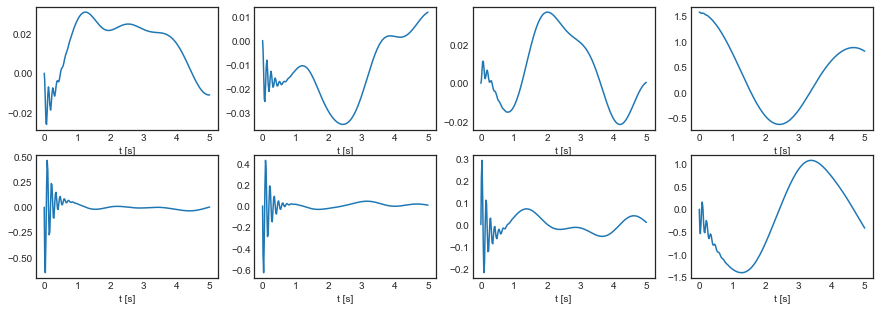

In [21]:
yi = yData.y
t = yData.t

plt.style.use('seaborn-white')

  
fig, axes = plt.subplots(2,int(len(yi)/2),figsize=(15,5))

for i in range(int(len(yi)/2)):
    # pos plot
    axes[0][i].plot(t,yi[i*2])
    axes[0][i].set_ylabel('')
    axes[0][i].set_xlabel('t [s]')
    
    # vel plot
    axes[1][i].plot(t,yi[i*2+1])
    axes[1][i].set_ylabel('')
    axes[1][i].set_xlabel('t [s]')